# **Lab Exercise \#10: Size of the Galaxy, Part 1**


## **Load Python modules/packages (Run this cell first every time)**

Run the following cell to load all the Python 3 modules and packages needed for this lab. 



In [2]:
## Import all the needed packages
import os
import glob

## Import astro packages
from astropy import *
import numpy as np
import astropy.io.fits as pyfits
from scipy import stats as sp_stats
from astropy.stats import sigma_clipped_stats
from astropy.time import Time

## photometry package
import photutils ## >>>>>>>> FOR THIS LAB, THIS IS A KEY PACKAGE
from photutils import datasets
from photutils import DAOStarFinder
from photutils import CircularAperture
from photutils import DAOStarFinder
from photutils import find_peaks
from photutils import aperture_photometry

## plotting packages
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use(astropy_mpl_style)
from skimage import data, img_as_float
from skimage import exposure

## helper packages
import urllib, zipfile, tarfile
from urllib.request import urlretrieve
import warnings

## **Load all the data needed for the lab**

The following cell retrieves all the data needed for this lab from the web. Just run the cell without any changes.

We first check if a Data directory exists in your Home/ directory, else we create it. Then the lab data are downloaded and saved in that directory. After you execute the following cell, go to the Data directory and check to make sure you have all the needed files (your TA will guide you in doing this).

In [4]:

# retrieve the data as a tarball from the UVic website, and untar in home dir
Lab10_datadir = 'SizeOfGalaxy'

# Check if data dir exists, else retrieve data from UVic website
if not(os.path.exists(Lab10_datadir) and os.path.isdir(Lab10_datadir)):
    url = 'http://astrowww.phys.uvic.ca/~karun/UVicAstrLabs/A250/'
    tgz = Lab10_datadir+'.tgz'
    outfile = tgz
    urlretrieve(url+tgz, filename=outfile)
    tar = tarfile.open(outfile)
    tar.extractall()
    tar.close()

print('Size of Galaxy Lab data dir: ',Lab10_datadir)
print('List of available files:')
file_list = glob.glob(Lab10_datadir+'/*.fits')
for file in file_list:
    print(file)


Size of Galaxy Lab data dir:  SizeOfGalaxy
List of available files:
SizeOfGalaxy/071600.fits
SizeOfGalaxy/081545.fits
SizeOfGalaxy/040720.fits
SizeOfGalaxy/024040.fits
SizeOfGalaxy/061200.fits
SizeOfGalaxy/045725.fits
SizeOfGalaxy/042540.fits
SizeOfGalaxy/080930.fits
SizeOfGalaxy/023920.fits
SizeOfGalaxy/082950.fits
SizeOfGalaxy/051110.fits
SizeOfGalaxy/074905.fits
SizeOfGalaxy/082300.fits
SizeOfGalaxy/033900.fits
SizeOfGalaxy/044515.fits
SizeOfGalaxy/032435.fits
SizeOfGalaxy/020440.fits
SizeOfGalaxy/043915.fits
SizeOfGalaxy/092100.fits
SizeOfGalaxy/090915.fits
SizeOfGalaxy/054045.fits
SizeOfGalaxy/045135.fits
SizeOfGalaxy/041325.fits
SizeOfGalaxy/073530.fits
SizeOfGalaxy/055818.fits
SizeOfGalaxy/035335.fits
SizeOfGalaxy/015005.fits
SizeOfGalaxy/034510.fits
SizeOfGalaxy/074220.fits
SizeOfGalaxy/094025.fits
SizeOfGalaxy/080220.fits
SizeOfGalaxy/015618.fits
SizeOfGalaxy/052540.fits
SizeOfGalaxy/072230.fits
SizeOfGalaxy/072900.fits
SizeOfGalaxy/084951.fits
SizeOfGalaxy/022815.fits
SizeOfG

## **Data Analysis**
## **(The first eight steps are very similar to the Star Counts lab)**

FOR YOUR DATA ANALYSIS, CHOOSE ANY ONE IMAGE FROM THE LIST ABOVE AND FOLLOW THESE STEPS:
    1. Get basic image information from the fits header.
    2. Read in the image and display it.
    3. Use the image display to choose an appropriate image sub-region for statistical analysis. **Make sure this sub-region contains the four RR Lyrae stars**
    4. Obtain some essential statistical characteristics of the image (using the sub-region) and estimate the sky background.
    5. Run DAOFIND on the sub-region to locate several bright (high SNR) stars.
    6. Do a **curve of growth** on one of the bright stars to estimate the optimal aperture for photometry.
    7. With the optimal aperture, re-run DAOFIND and DAOPHOT to carry out aperture photometry.
    8. Convert the stellar flux values returned by DAOPHOT to apparent magnitudes.
    9. Build a function to match objects in two catalogs based on their x,y (pixel) positions. Use this function to match the positions of the four RR Lyrae stars and four comparison stars with the list of all stars and thus get their apparent magnitudes.
    10. **IMPORTANT STEP** Build a function to carry out the aperture photometry on all the other images (use the same sub-region, optimal aperture and zeropoint).
    11. The apparent magnitudes of the four comparison stars are used to estimate any _small_ zeropoint offsets from one image to the next.
    12. The apparent magnitudes of the four RR Lyrae stars are used to construct their light curves, and thus estimate their mean apparent magnitudes.
    
#### **ACKNOWLEDGEMENT: The images of the globular cluster, M3 containing the RR Lyrae stars we will use in this part of the lab were taken at the Applachian State University by Dan Canton **

### **STEP 1: Get image information from the fits header**

**Getting basic header info from the image. For your lab exercise, replace 015005.fits with any one of the other images.** 


In [6]:
## READ THE IMAGE HEADER AND LIST THE DETAILS
Lab10_datadir = 'SizeOfGalaxy'
fits_filename = '084331.fits'
infits = os.path.join(Lab10_datadir,fits_filename)
image_header = pyfits.getheader(infits, ext=0) ## this header info is needed for later
## LIST OUT THE REQUIRED HEADER DETAILS
header_details = ['NAXIS1','NAXIS2','PSF-FWHM','DATEFITS']
for header_name in header_details:
    header_value = image_header[header_name]
    print(header_name,' = ',header_value)
    
## CONVERT DATEFITS TO MJD
obs_datetime = Time(image_header['DATEFITS'], format='fits', scale='utc')
obj_mjd = obs_datetime.mjd
print('Observed MJD = %f' % (obj_mjd))
Ref_objmjd = obj_mjd # store this for later analysis

NAXIS1  =  1024
NAXIS2  =  1024
PSF-FWHM  =  5.66919
DATEFITS  =  2000-07-25T17:18:30
Observed MJD = 51750.721181


### **STEP 2: READ IN THE IMAGE OF M3, AND DISPLAY IT**

**IMAGE DATA. Remember to change the file name.**

In the following cell, read in the image data, and display it. 

Number of rows, columns in image: 1024 1024


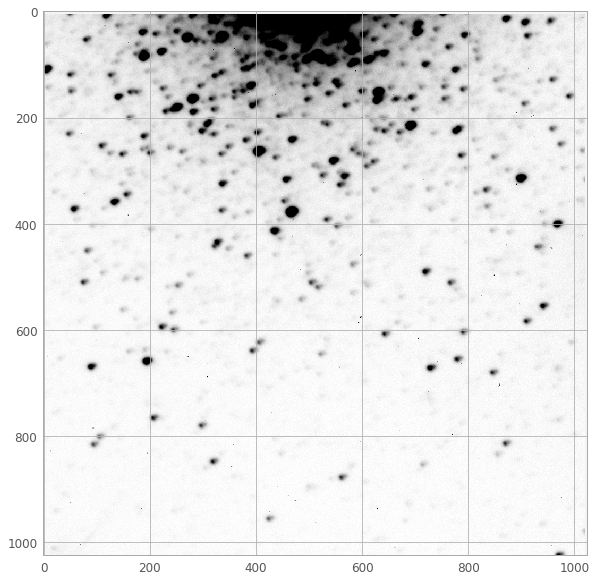

In [7]:
# READ THE IMAGE DATA
image_data = pyfits.getdata(infits,ext=0)
image_data = image_data[0,:,:]
image_data = np.flipud(image_data)

# SCALE AND DISPLAY THE IMAGE, and choose an appropriate sub-region
plt.figure(figsize=(10,10))
# plt.figure()
# In this we are using Contrast stretching, 
# and inverted grey scale for better display
p2, p98 = np.percentile(image_data, (2, 98))
img_rescale = exposure.rescale_intensity(image_data, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')
# plt.imshow(image_data, cmap='gray_r')

# Find the size of the image data array
[rows,cols] = image_data.shape
print('Number of rows, columns in image: %d %d' % (rows,cols))

### **STEP 3: CHOOSE A SUB-REGION CONTAINING THE RR LYRAE STARS**

Look at the image display above and choose an appropriate sub-region which contains the four RR Lyrae stars, as well as several comparison stars. 

**These images have not been sky subtracted**. Therefore, the flux in any pixel contains contribution from the sky background. This sky background value has to be subtracted before we can do photometry (=measure the flux and magnitude of the stars). In this lab, _we will assume that the sky background is uniform over the entire image_. 

To estimate the sky background, we will use this sub-region of the image.

**IMPORTANT NOTE: PYTHON IS ROW DOMINANT, SO WHILE CHOOSING SUB-REGIONS, THE FIRST SET OF COORDINATES RUNS THE IN THE VERTICAL DIRECTION (ROWS), AND THE SECOND SET RUNS ALONG THE HORIZONTAL DIRECTION (COLUMNS).**

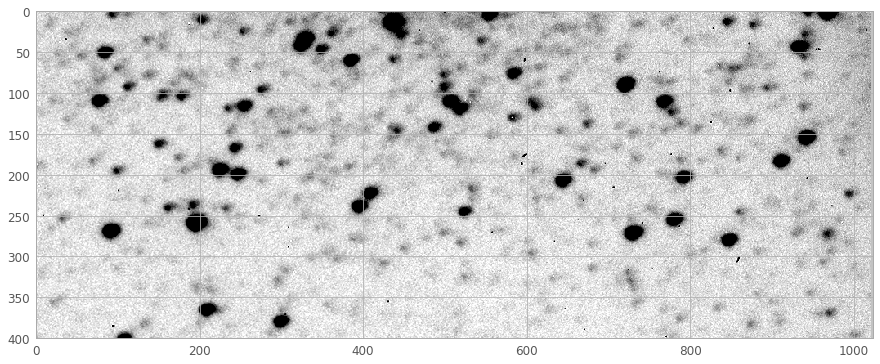

In [8]:
# Enter the row and column range of your chosen sub-region. 
# Ensure the chosen sub-region contains the four RR Lyrae stars
row_start = 400
row_end = 800
image_region = image_data[row_start:row_end,:]

# SCALE AND DISPLAY THE IMAGE SUB-REGION
plt.figure(figsize=(15,30))
# In this we are using Contrast stretching, 
# and inverted grey scale for better display
p2, p98 = np.percentile(image_region, (2, 98))
img_rescale = exposure.rescale_intensity(image_region, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')

### **STEP 4: GET SOME BASIC STATISTICS OF THE SUB-REGION**

We will estimate the sky background using sigma-clipped statistics. This will minimize the effects of outliers. The sky background is taken to be the median value after sigma clipping.

Sigma clipping is a useful technique to get **robust statistics in the presence of outliers**.


In [9]:
# SOME BASIC STATS OF TEH SUB-REGION NEEDED FOR SKY SUBTRACTION

## USE SIGMA CLIPPING TO REJECT OUTLIERS
sc_mean, sc_median, sc_stddev = sigma_clipped_stats(image_region, sigma=5.0, iters=5)
print('After sigma clipping: Mean, Stddev, Median : %9.1f %9.1f %9.1f ' % (sc_mean,sc_stddev,sc_median))

After sigma clipping: Mean, Stddev, Median :     171.8      15.9     169.0 


### **STEP 5: DETECTION OF STARS (SOURCES) USING DAOFIND**

**Use the statistical estimate (= the standard deviation) to set the threshold, and find the positions of the stars in the image**

Before we can measure the brightness of the stars in the image, we need to find their locations and also the optimal aperture size to use for measuring their flux. The aperture size is dependent on the point spread function (PSF) during the observation.

We will locate only the bright stars first using an approximate aperture size, then refine the aperture size based on one (user chosen) good star. In order to find only bright stars, we will set the detection threshold to be 10$\sigma$ above the sky background. The noise level, $\sigma$ is equal to the standard deviation *sc_stddev*

**_DAOFIND_ and _DAOPHOT II: The Next Generation_ were developed by Dr. Peter Stetson at the DAO, and has become an industry standard for crowded field astrometry and photometry.** Additional details are available online at various websites, such as <a href="http://www.star.bris.ac.uk/~mbt/daophot/" target="_blank">Starlink</a>. 

  id   xcentroid ycentroid sharpness roundness1 ...  sky    peak    flux  mag  
------ --------- --------- --------- ---------- ... ----- -------- ----- ------
 1.000   433.627    13.216     0.455      0.432 ... 0.000 1466.000 2.091 -0.801
 2.000   326.630    34.655     0.434      0.186 ... 0.000 1050.000 1.602 -0.511
 3.000   382.475    60.103     0.446      0.119 ... 0.000  595.000 1.080 -0.084
 4.000   718.567    89.933     0.410      0.077 ... 0.000 1005.000 1.626 -0.527
 5.000    75.017   109.852     0.443      0.086 ... 0.000  648.000 1.243 -0.236
 6.000   765.661   110.652     0.375      0.143 ... 0.000  593.000 1.050 -0.053
 7.000   940.019   154.713     0.407      0.181 ... 0.000 1071.000 1.893 -0.693
 8.000   909.001   183.371     0.377      0.136 ... 0.000  714.000 1.220 -0.216
 9.000   222.393   194.362     0.444      0.299 ... 0.000  815.000 1.481 -0.426
10.000   244.553   199.436     0.446      0.235 ... 0.000  598.000 1.087 -0.091
11.000   789.807   203.450     0.525    

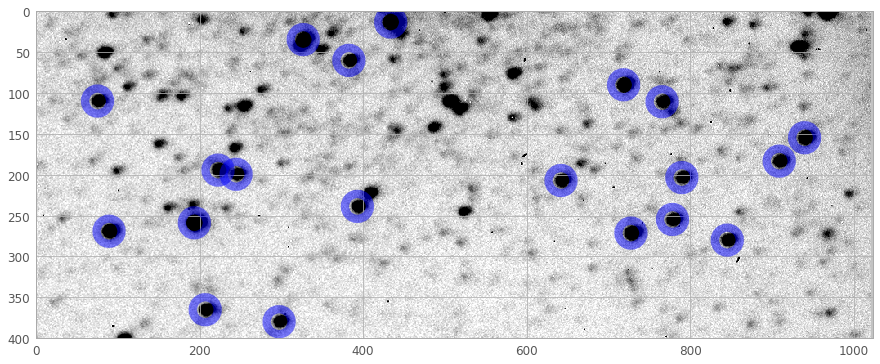

In [12]:
approx_fwhm = 5 # pixels
threshold_sigma = 23. # CHANGE THIS VALUE AS NEEDED
daofind = DAOStarFinder(fwhm=approx_fwhm, threshold=threshold_sigma*sc_stddev) 
sources = daofind(image_region - sc_median)
for colname in sources.colnames:
    sources[colname].info.format = '%.3f'
print(sources)
# print(type(sources))

## PLOT THE REGION AND OVERPLOT THE BRIGHT STARS
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=approx_fwhm)

plt.figure(figsize=(15,30))
p2, p98 = np.percentile(image_region, (2, 98))
img_rescale = exposure.rescale_intensity(image_region, in_range=(p2, p98))
plt.imshow(img_rescale, cmap='gray_r')
apertures.plot(color='blue', lw=5*approx_fwhm, alpha=0.5)

OBJcol_vect = sources['xcentroid']
OBJrow_vect = sources['ycentroid']
nobj = len(OBJcol_vect)
print('Number of objects detected: %d' % (nobj))

###  **IMPORTANT**

Make two lists of the (row,column) of the centroids of the four RR Lyrae stars, as well as four unblended comparison stars. We need these lists for matching these stars on all the other images.

**CAUTION: DAOFIND GOES BY XCENTROID = COLUMN NUMBER (along the horizontal axis), AND YCENTROID = ROW NUMBER (along the vertical axis).**

This is different from the convention used by Python, so pay attention!

In [25]:
# THIS DOES NOT WORK, DO NOT USE THESE!
# RRcol_vect = [89.9,728.6,940.9,909.8,207.8,298.1,779.4,846.5]
# RRrow_vect = [168.7,171.2,54.1,82.8,264.9,279.0,154.1,179.6]

# ENTER YOUR COORDINATES HERE!
RRcol_vect = [89.069,727.546,909.001,940.019,193.416,326.630,75.017,718.567]
RRrow_vect = [269.134,271.393,183.371,154.713,258.812,34.655,109.852,89.933]

###  **STEP 6: CURVE OF GROWTH TO FIND THE OPTIMAL APERTURE**

In the DAOFind output table above, the locations of the bright stars are given by the columns _xcentroid_ and _ycentroid_. Choose any one of those stars which is unsaturated (without diffraction spikes).

Define a series of apertures of increasing size, and estimate the flux contained within each. Determine the optimal aperture as the one which contains all the flux without including too many sky pixels.

**NOTE: Test the following cell with several stars, and check if you get consistent values of the optimal aperture**.


Text(0,0.5,'Total flux [ADU]')

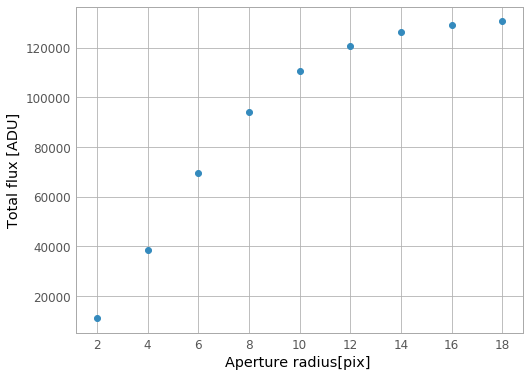

In [29]:
## CHOOSE ANY BRIGHT, UNSATURATED STAR FROM THE LIST ABOVE
## SPECIFY THE STAR TO USE BY THE STAR ID number
star_id = 20
star_num = star_id - 1
positions = [(sources['xcentroid'][star_num],sources['ycentroid'][star_num])]
## Create a list of apertures of increasing radius
aperture_list = range(2,20,2) ## min = 2 pix, max = 20 pix, step = 2
flux_list = [] ## create an empty list to hold the measured flux in each aperture
for aperture_radius in aperture_list:
    apertures = CircularAperture(positions, r=aperture_radius)
    phot_table = aperture_photometry(image_region-sc_median, apertures)
    flux_value = phot_table['aperture_sum'][0]
    flux_list.append(flux_value)

## Plot apertures versus measured flux, determine the optimal aperture size
plt.scatter(aperture_list, flux_list)
plt.xlabel('Aperture radius[pix] ')
plt.ylabel('Total flux [ADU]')

#### **Make a note of the optimal aperture radius ** 

We can see that the curve of growth _flattens_ or levels off with increasing radius. The radius at which this happens is the optimal aperture radius. Enter this value in the following code cell.   

**IMPORTANT** At much larger apertures, the flux (sometimes) continues to increase. This is due to contributions from sky noise as well as any nearby stars. _These should not be included in the estimate of the flux of the star_.

### **STEP 7: CARRY OUT APERTURE PHOTOMETRY ON ALL THE SOURCES IN THE IMAGE**

Now we are ready to detect all the sources in the image and carry out aperture photometry to determine their magnitudes.

Note that we use the optimal aperture size for this step. 

The parameter, _nsigma_, sets the magnitude threshold up to which we detect stars. Increasing this value will return only the brighter stars. 

In [30]:
optimal_aperture = 16 ## determined above
nsigma = threshold_sigma ## this determines how faint we wish to go in detecting sources

## DETECT SOURCES IN TEH FULL IMAGE
daofind = DAOStarFinder(fwhm=optimal_aperture, threshold=nsigma*sc_stddev) 
sources = daofind(image_region - sc_median) ## detect sources in the full image

## NOW CARRY OUT APERTURE PHOTOMETRY ON ALL THE SOURCES
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=optimal_aperture)
phot_table = aperture_photometry(image_region - sc_median, apertures)
for colname in phot_table.colnames:
    phot_table[colname].info.format = '%.3f'
print(phot_table[:])


  id   xcenter ycenter aperture_sum
         pix     pix               
------ ------- ------- ------------
 1.000 944.015   2.863    24692.344
 2.000 966.916   2.687   138524.521
 3.000  93.054   4.036    13728.110
 4.000 553.085   4.745    58613.548
 5.000 202.164   9.882    24828.049
 6.000 845.526  12.357    20795.446
 7.000 435.128  13.263   243074.838
 8.000 877.669  15.813    14682.432
 9.000 252.878  23.767    16332.881
10.000 361.923  25.772    28361.460
   ...     ...     ...          ...
53.000 779.518 254.590    89931.340
54.000 194.510 258.548   295768.200
55.000  90.110 268.818   140914.511
56.000 728.783 271.109   137820.945
57.000 968.302 271.977    22707.948
58.000 846.523 279.731    75180.169
59.000 207.986 364.970    80649.787
60.000 970.327 368.614    11595.213
61.000 298.173 379.406    65725.016
62.000 107.644 396.958    19563.599
Length = 62 rows


### **STEP 8: Convert the total flux (given in _aperture sum_) to _magnitude_** 

The _aperture sum_ is in ADU. We need to covnert that into _apparent magnitude_. For this conversion, we need the flux _Zero Point_ (ZP) of this image. The Zero Point is obtained by observing a _flux standard star_.

Apparent magnitude = -2.5 $log_{10}$(aperture sum) + ZP

**NOTE** Before doing the conversion, reject any objects with negative flux (due to poor photometry near detector edges, cosmic rays, and other defects).

**FOR THESE OBSERVATIONS, (as given in the lab manual) THE ZEROPOINT = 27.93**


In [31]:
# Flux zeropoint 
ZP = 27.93

# extract the aperture sum column from the phot table
aperture_sum = phot_table['aperture_sum']
xcenter = phot_table['xcenter']
ycenter = phot_table['ycenter']
napertures = len(aperture_sum)

## You notice that some aperture sum values are negative
## remove thse values which are below zero (affected by bad pixels, bad CCD columns, etc.)
## good_aperture_sum = [flux for flux in aperture_sum if flux > 0.]
good_index = [indx for indx in range(napertures) if aperture_sum[indx] > 0.]

good_aperture_sum = np.asarray(aperture_sum[good_index])
xcenter = np.asarray(xcenter[good_index])
ycenter = np.asarray(ycenter[good_index])

## calculate the magnitude 
log10_flux = np.log10(good_aperture_sum)
apparent_magnitude = np.multiply(-2.5,log10_flux) + ZP

## check the selection step worked fine
print('%10s %10s' % ('Flux','Magnitude'))
for indx in range(10):
    print('%10.1f %10.3f' % (good_aperture_sum[indx],apparent_magnitude[indx]))

      Flux  Magnitude
   24692.3     16.949
  138524.5     15.076
   13728.1     17.586
   58613.5     16.010
   24828.0     16.943
   20795.4     17.135
  243074.8     14.466
   14682.4     17.513
   16332.9     17.397
   28361.5     16.798


## **STEP 9: Extract only the RR Lyr and Comparison Stars Magnitudes**

### **IMPORTANT STEP**

**Learn how to write a Python function** 

Match the x,y positions of the RR Lyr and comparison stars to the x,y positions in the list you created on Step 5. We will build a small function to do this position matching


In [35]:
def match_indices(x0,y0,xlist,ylist):
    # for a list of objects positions x0 and y0
    # match each object with the longer list of positions, xlist, ylist
    # and return the indices of the matches in the list
    # If there is no match, return -99
    
    ninlist = len(x0)
    out_indices = np.zeros(ninlist,dtype=int)-99
    out_mindist = np.zeros(ninlist,dtype=int)-99
    
    # loop through the input list matching each object by nearest square distance
    for indx in range(ninlist):
        tmpx = x0[indx]
        tmpy = y0[indx]
        xdist = xlist - tmpx
        ydist = ylist - tmpy
        # dist2 = np.sum(np.multipy(xdist,xdist),np.multiply(ydist,ydist))
        dist2 = xdist*xdist + ydist*ydist
        distval = np.sqrt(dist2)
        tmpindx = np.argmin(distval)
        out_indices[indx] = tmpindx
        out_mindist[indx] = distval[tmpindx]

    # check how many obj were matched
    # return all indices included unmatched ones
    match_indices = [indx for indx in out_indices if indx != -99]
    nmatched = len(match_indices)
    # print('Number of objects input: %d' % (ninlist))
    # print('Number of ojbects matched: %d' % (nmatched))
    return [out_indices,out_mindist]

### **Sanity check**

Match the positions of the RR Lyrae stars and comparison stars you identified, with the positions of all the objects in the photometric table. Print out the positions of the RR Lyr stars and the comparison stars along with their magnitudes. Cross check with the positions you identified earlier (Step 5) to confirm the matching worked fine.

In [34]:
# Use the function above to match the positions of the RR Lyr and comparison stars 
# with the list of objects for which we have photometry on Step 8

[matched_obj,out_mindist] = match_indices(RRcol_vect,RRrow_vect,xcenter,ycenter)

for indx in matched_obj:
    print('%.1f %.1f %.3f' % (xcenter[indx],ycenter[indx],apparent_magnitude[indx]))
    
## Store the RR Lyrae stars' magnitudes and the Comparison stars' magnitudes 
## in separate arrays for later processing
## THESE MAGS ARE TAKEN TO BE THE REFERENCE MAGS
RRLyr_refmags = apparent_magnitude[matched_obj[0:4]]
Comp_refmags = apparent_magnitude[matched_obj[4:8]]
## CONVERT TO COLUMN VECTORS FOR LATER USE
RRLyr_refmags = RRLyr_refmags.reshape((1,4))
Comp_refmags = Comp_refmags.reshape((1,4))

90.1 268.8 15.058
728.8 271.1 15.082
910.1 183.0 15.623
941.1 154.4 15.179
194.5 258.5 14.253
327.0 35.6 14.779
76.2 109.5 15.765
719.7 89.7 15.153


## **STEP 10: RUN PHOTOMETRY ON ALL THE INPUT FITS IMAGES**

### **VERY IMPORTANT STEP! We will write a function to do all the above steps on any given input image**

Write a function to carry out the aperture photometry on all the objects in all the images of M3. For each image, use the matching function (Step 9) to then extract the magnitudes of the four RR Lyr stars as well as the four comparison stars. 


In [36]:
def dophot_image(infits,RRcol_vect,RRrow_vect,
                                row_start=row_start,row_end=row_end,
                                optimal_aperture=optimal_aperture,
                                nsigma=nsigma,
                                ZP=ZP):
    
    # READ THE IMAGE HEADER TO GET DATE/TIME OF OBSERVATION
    image_header = pyfits.getheader(infits, ext=0)
    obs_datetime = Time(image_header['DATEFITS'], format='fits', scale='utc')
    obj_mjd = obs_datetime.mjd
    # READ THE IMAGE DATA
    image_data = pyfits.getdata(infits,ext=0)
    image_data = image_data[0,:,:]
    image_data = np.flipud(image_data)
    # CUT OUT THE SUB-REGION AND ESTIMATE THE SKY BACKGROUND
    image_region = image_data[row_start:row_end,:]
    sc_mean, sc_median, sc_stddev = sigma_clipped_stats(image_region, sigma=5.0, iters=5)
    ## DETECT SOURCES
    daofind = DAOStarFinder(fwhm=optimal_aperture, threshold=nsigma*sc_stddev) 
    sources = daofind(image_region - sc_median) ## detect sources in the full image
    ## NOW CARRY OUT APERTURE PHOTOMETRY ON ALL THE SOURCES
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=optimal_aperture)
    phot_table = aperture_photometry(image_region - sc_median, apertures)
    # EXTRACT THE X,Y CENTERS AND FLUX COLUMNS FROM THE PHOT TABLE
    aperture_sum = phot_table['aperture_sum']
    xcenter = phot_table['xcenter']
    ycenter = phot_table['ycenter']
    napertures = len(aperture_sum)
    # REMOVE ANY APERTURES WITH NEGATIVE FLUX VALUES
    good_index = [indx for indx in range(napertures) if aperture_sum[indx] > 0.]
    good_aperture_sum = np.asarray(aperture_sum[good_index])
    xcenter = np.asarray(xcenter[good_index])
    ycenter = np.asarray(ycenter[good_index])
    ## USE THE ZERO POINT TO CALCULATE THE APPARENT MAGNITUDES
    log10_flux = np.log10(good_aperture_sum)
    apparent_magnitude = np.multiply(-2.5,log10_flux) + ZP
    ## MATCH THE RR LYR AND COMPARISON STARS POSITIONS WITH THOSE 
    ## IN THE PHOT LIST
    [matched_obj,out_mindist] = match_indices(RRcol_vect,RRrow_vect,xcenter,ycenter)
    ## EXTRACT THE X,Y POSITIONS AND APPARENT MAGNITUDES OF THE RR LYR
    ## AND THE COMPARISON STARS
    ## IF THE MATCH DID NOT WORK, RETURN SOME DEFAULT VALUE FOR THE MAGNITUDE = -99
    ## AND POSITIONS, X,Y = 0
    nout = len(matched_obj)
    xout = np.zeros(nout)
    yout = np.zeros(nout)
    magout = np.zeros(nout)-99
    nfound = 0
    for indx in range(nout):
        if (matched_obj[indx] != -99): # ensure the match worked
            xout[indx] = xcenter[matched_obj[indx]]
            yout[indx] = ycenter[matched_obj[indx]]
            magout[indx] = apparent_magnitude[matched_obj[indx]]
            nfound += 1
    ## RETURN ALL THESE VALUES
    return [obj_mjd,nout,nfound,xout,yout,magout]

## **Run the photometric function on all the input images**



In [38]:
# Define arrays to hold all the output values
ninfits = len(file_list)
nstars = len(RRcol_vect)
obj_mjd_vect = np.zeros(ninfits)
nout_vect = np.zeros(ninfits)
nfound_vect = np.zeros(ninfits)
xout_vect = np.zeros((ninfits,nstars))
yout_vect = np.zeros((ninfits,nstars))
magout_vect = np.zeros((ninfits,nstars))
print('%15s %8s %8s %8s %8s %10s' % ('obs_mjd','n_input','n_match','xout[0]','yout[0]','magout[0]'))
for indx in range(ninfits):
    infits = file_list[indx]
    [obj_mjd,nout,nfound,xout,yout,magout] = dophot_image(infits,RRcol_vect,RRrow_vect,
                                row_start=row_start,row_end=row_end,
                                optimal_aperture=optimal_aperture,
                                nsigma=nsigma,
                                ZP=ZP)
    obj_mjd_vect[indx] = obj_mjd
    nout_vect[indx] = nout
    nfound_vect[indx] = nfound
    xout_vect[indx,:] = xout
    yout_vect[indx,:] = yout
    magout_vect[indx,:] = magout
    # as a sanity check only print out values for the first RR Lyr star
    print('%15.8f %8d %8d %8.1f %8.1f %10.3f' % (obj_mjd,nout,nfound,xout[0],yout[0],magout[0]))


print('================================================')
print('Number of images processed: ',ninfits)

        obs_mjd  n_input  n_match  xout[0]  yout[0]  magout[0]
 51750.71920139        8        8     89.9    268.8     15.987
 51750.72069444        8        8     90.0    268.8     14.988
 51750.71439815        8        8     90.0    268.7     16.251
 51750.71196759        8        8     90.0    268.7     16.299
 51750.71806713        8        8     90.0    268.8     16.276
 51750.71560185        8        8     90.0    268.8     16.204
 51750.71497685        8        8     90.1    268.8     16.228
 51750.72032407        8        8     90.2    268.8     15.026
 51750.71180556        8        8     90.1    268.8     16.292
 51750.72101852        8        8     90.2    268.8     15.037
 51750.71576389        8        8     90.0    268.8     16.147
 51750.72004630        8        8     89.9    268.7     15.098
 51750.72086806        8        8     90.0    268.8     15.027
 51750.71311343        8        8     90.1    268.7     16.266
 51750.71527778        8        8     90.0    268.8    

## **STEP 11: ZP correct and plot the magnitudes of the RR Lyrae stars**

Assuming everything has gone fine so far, we notice the mjd is not sorted in ascending order (time of observation is not sequential). So we need to first sort all these lists.

Then, we will correct the magnitudes of the RR Lyrae stars in each image using the median offsets in the magnitudes of the four comparison stars (when compared to their magnitudes in the reference image).

Finally, we will plot the corrected magnitudes of the four RR Lyrae stars in four panels. We will also get the mean magnitude of the four RR Lyrae stars, which is then used to calculate the distance to M3. 

In [39]:
## get the sorted indices of the MJD
sort_index = np.argsort(obj_mjd_vect)

## Now sort all the vectors and arrays
obj_mjd_vect = obj_mjd_vect[sort_index]
nout_vect = nout_vect[sort_index]
nfound_vect = nfound_vect[sort_index]
xout_vect = xout_vect[sort_index,:]
yout_vect = yout_vect[sort_index,:]
magout_vect = magout_vect[sort_index,:]


## Split the magnitude array into two parts, one for RR Lyrae, 
## and the other for the comparison stars
RRLyr_mags = magout_vect[:,0:4]
Comp_mags = magout_vect[:,4:8]

## Print out a few values to check that everything worked alright so far
for indx in range(10):
    print('%15.8f %10.3f %10.3f' % (obj_mjd_vect[indx],magout_vect[indx,0],RRLyr_mags[indx,0]))


 51750.71070602     16.282     16.282
 51750.71086806     16.277     16.277
 51750.71129630     16.275     16.275
 51750.71145833     16.327     16.327
 51750.71163194     16.279     16.279
 51750.71180556     16.292     16.292
 51750.71196759     16.299     16.299
 51750.71214120     16.251     16.251
 51750.71236111     16.318     16.318
 51750.71256944     16.284     16.284


### **Compute the median ZP offset using the comparison stars**

    1. For each image, calculte the difference between the magnitude of each comparison star and its magnitude in the reference image
    2. Calculate the median offset in each image using the offsets of the four comparison stars.
    3. This median value is taken to be the zeropoint offset with respect to the reference image.
    4. We will then apply this offset to the magnitudes of the RR Lyrae stars.

In [40]:
# calculate the magnidtude offset for each star on each image
# NOTE: We are subtracting one array from another. Each array is a different shape
# but Python can handle this using 'broadcasting' (search online for description)
mag_offset = Comp_mags - Comp_refmags
print('Shapes of the arrays')
print(Comp_mags.shape)
print(Comp_refmags.shape)
print(mag_offset.shape)
print('---------------------')
print('Mag offsets per image;')
print('(First image is reference, offset = 0)')
for indx in range(10):
    print(mag_offset[indx,:])
## NOTE: The first image is the reference image, that is why the offset is 0!

# Now calculate the median offset of the four comparison stars on each image
# The median is computed along the row (Note the parameters used, axis and keepdims)
med_mag_offset = np.median(mag_offset,axis=1,keepdims=True)
# print out a few values to check
print('---------------------')
print('Median mag offset per iamge')
for indx in range(10):
    print(med_mag_offset[indx])


Shapes of the arrays
(53, 4)
(1, 4)
(53, 4)
---------------------
Mag offsets per image;
(First image is reference, offset = 0)
[ 0.07746483  0.08345567  0.09938265  0.41632681]
[ 0.07520463  0.07761253  0.0892631   0.41531823]
[ 0.05153014  0.05855163  0.07034523  0.39187849]
[ 0.06075549  0.07651281  0.07880234  0.42407522]
[ 0.02299657  0.02726792  0.00392945  0.37600466]
[ 0.01044434  0.01775104  0.03759732  0.35295498]
[ 0.01048771  0.0067318   0.03405237  0.35266601]
[-0.0114838  -0.01297082  0.00457934  0.33439874]
[ -1.60573871e-04   6.49578574e-03   2.12751921e-02   3.45503809e-01]
[-0.00917    -0.00882854 -0.0127526   0.3472591 ]
---------------------
Median mag offset per iamge
[ 0.09141916]
[ 0.08343782]
[ 0.06444843]
[ 0.07765758]
[ 0.02513225]
[ 0.02767418]
[ 0.02227004]
[-0.00345223]
[ 0.01388549]
[-0.00899927]


### **Apply the zeropoint offsets to the magnitudes of the RR Lyrae stars**

In [41]:
# Subtract the offset, 
# this will put the magnitudes on the same scale as the reference image
corr_RRLyr_mags = RRLyr_mags - med_mag_offset

# Print out the first few values as a sanity check
print('RR Lry 1 mag: uncorrectd mag, zp offset and corrected mag')
for indx in range(10):
    print(RRLyr_mags[indx,0],med_mag_offset[indx],corr_RRLyr_mags[indx,0])


RR Lry 1 mag: uncorrectd mag, zp offset and corrected mag
16.282208609 [ 0.09141916] 16.1907894496
16.2770514676 [ 0.08343782] 16.1936136508
16.2751255686 [ 0.06444843] 16.2106771391
16.3265890778 [ 0.07765758] 16.2489315027
16.2785930639 [ 0.02513225] 16.2534608176
16.2919179653 [ 0.02767418] 16.2642437868
16.2989113947 [ 0.02227004] 16.2766413576
16.2507405671 [-0.00345223] 16.2541927952
16.3182360542 [ 0.01388549] 16.3043505653
16.2841595899 [-0.00899927] 16.2931588569


## **STEP 12: Plot the four RR Lyr zeropoint corrected mags as a function of time (called a _Light Curve_)**

Use four subplots to show each zp corrected RR Lyr _light curve_ in a separate panel.

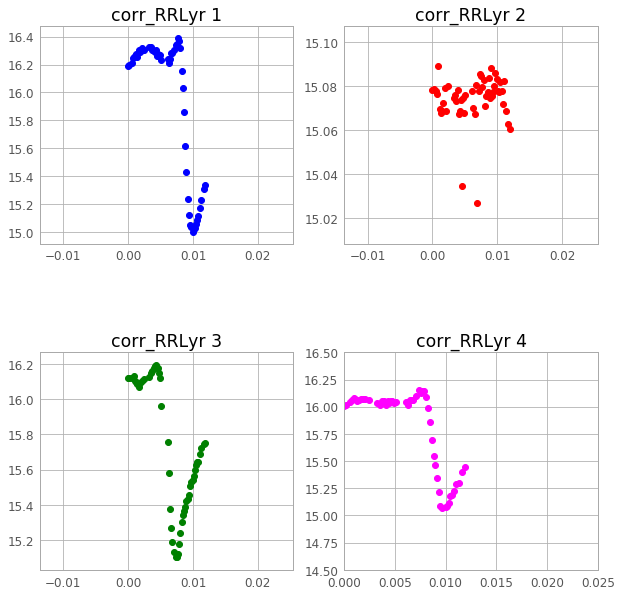

In [42]:
obj_mjd_vect_offs = obj_mjd_vect - min(obj_mjd_vect)
# plt.scatter(obj_mjd_vect_offs, RRLyr_mags[:,3], marker='o', color='blue')
# plt.xlim(0,0.0125)
# plt.ylim(14.5,16.5)
# sharex='col', sharey='row', 

# create subplots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
plt.xlim(0,0.025)
plt.ylim(14.5,16.5)
# subplot 1
ax1.scatter(obj_mjd_vect_offs, corr_RRLyr_mags[:,0], marker='o', color='blue')
ax1.set_title('corr_RRLyr 1')
# plt.xlim(0,0.0125)
# plt.ylim(14.5,16.5)
# subplot 2
ax2.scatter(obj_mjd_vect_offs, corr_RRLyr_mags[:,1], marker='o', color='red')
ax2.set_title('corr_RRLyr 2')
# plt.xlim(0,0.0125)
# plt.ylim(14.5,16.5)
# subplot 3
ax3.scatter(obj_mjd_vect_offs, corr_RRLyr_mags[:,2], marker='o', color='green')
ax3.set_title('corr_RRLyr 3')
# plt.xlim(0,0.025)
# plt.ylim(14.5,16.5)
# subplot 4
ax4.scatter(obj_mjd_vect_offs, corr_RRLyr_mags[:,3], marker='o', color='magenta')
ax4.set_title('corr_RRLyr 4')
# plt.xlim(0,0.025)
# plt.ylim(14.5,16.5)
plt.show()

## **STEP 13: Calculate the mean magnitude of each RR Lyrae star**

As given in the manual, the mean magnitude of each RR Lyrae star is simply taken to be the difference between the maximum and mimimum value.

**NOTE:** This is a simplification. In reality, the full light curve has to be repeatedly observed several times, in order to estimate a robust mean magnitude.

In [43]:
# NOTE THAT THIS COMPUTES THE MAX AND MIN FOR ALL ROWS FOR EACH COLUMN
max_RRLyr_mag = np.amax(corr_RRLyr_mags,axis=0)
min_RRLyr_mag = np.amin(corr_RRLyr_mags,axis=0)

# PRINT OUT THE MAX, MIN VALUES AND CHECK IF THEY LOOK REASONABLE 
# USING THE PLOT ABOVE
print(max_RRLyr_mag)
print(min_RRLyr_mag)

[ 16.39054184  15.08889117  16.19572928  16.15337047]
[ 14.99974275  15.02658677  15.10062402  15.07278384]


## **STEP 14: Estimate the distance to M3 using the magnitude of the RR Lyrae stars**

The mean _absolute_ magnitude of a RR Lyrae = +0.7 +/- 0.1 mag (as given in the manual)

Use the equation given in the manual to compute the distance to M3 and the corresponding uncertainty.


In [44]:
mean_RRLyr_absmag = 0.7
mean_RRLyr_appmag = (max_RRLyr_mag + min_RRLyr_mag)/2.
exponen = (mean_RRLyr_appmag - mean_RRLyr_absmag)*0.2 + 1.
dist2M3 = np.power(10.,exponen)
print('Estimated distances to M3: [pc]',dist2M3)

# NOTE THAT THE SECOND RR LYR HAS NOT BEEN WELL SAMPLED
# DO NOT USE FOR THE DISTANCE CALCULATION
# Compute the mean value of the other three 
mean_dist2M3 = np.mean([dist2M3[0],dist2M3[2],dist2M3[3]])
print('==================================================')
print('Mean distances to M3: %.2e [pc]' % (mean_dist2M3))


Estimated distances to M3: [pc] [ 9977.6544429   7439.56930561  9764.16994285  9607.61143273]
Mean distances to M3: 9.78e+03 [pc]
